In [1]:
# ignore all future warnings
from warnings import simplefilter
simplefilter(action='ignore', category=FutureWarning)

In [2]:
# imports
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

In [3]:
# given by the assignment
def loadData():
    with np.load('notMNIST.npz') as data :
        Data, Target = data['images'], data['labels']
        posClass = 2
        negClass = 9
        dataIndx = (Target==posClass) + (Target==negClass)
        Data = Data[dataIndx]/255.
        Target = Target[dataIndx].reshape(-1, 1)
        Target[Target==posClass] = 1
        Target[Target==negClass] = 0
        np.random.seed(421)
        randIndx = np.arange(len(Data))
        np.random.shuffle(randIndx)
        Data, Target = Data[randIndx], Target[randIndx]
        trainData, trainTarget = Data[:3500], Target[:3500]
        validData, validTarget = Data[3500:3600], Target[3500:3600]
        testData, testTarget = Data[3600:], Target[3600:]
    return trainData, validData, testData, trainTarget, validTarget, testTarget

In [4]:
trainData, validData, testData, trainTarget, validTarget, testTarget = loadData()
print(f"Training Data: {trainData.shape}\tTraining tagets: {trainTarget.shape}")
print(f"Validation Data: {validData.shape}\tValidation tagets: {validTarget.shape}")
print(f"Testing Data: {testData.shape}\tTesting tagets:{testTarget.shape}")

Training Data: (3500, 28, 28)	Training tagets: (3500, 1)
Validation Data: (100, 28, 28)	Validation tagets: (100, 1)
Testing Data: (145, 28, 28)	Testing tagets:(145, 1)


In [32]:
def plot(image, target, ax=None):
    ax = plt if ax == None else ax
    ax.imshow(image, cmap="hot")
    ax.set_title('J' if target == 0 else 'C')
    # targets are binary encoded 0 == 'J' and 1 == 'C'

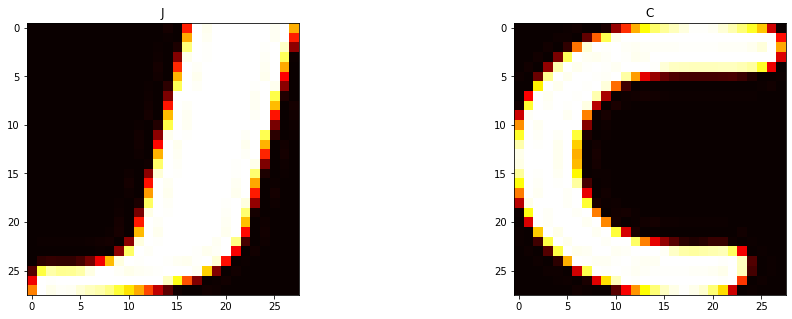

In [34]:
fig, ax = plt.subplots(1, 2, figsize=(16, 5))
plot(trainData[0], trainTarget[0], ax=ax[0])
plot(trainData[1], trainTarget[1], ax=ax[1])
plt.show()

In [7]:
def augment(X, w, b):
    # flatten X
    if len(X.shape) == 3:
        X = X.reshape(X.shape[0], -1)
    
    # insert 1's at position 0 along the columns
    X = np.insert(X, 0, 1, axis=1)
    
    # insert b at the front of W
    w = np.insert(w, 0, b, axis=0)
    
    return X, w

In [8]:
def predict(w, b, X):
    X = X.reshape(X.shape[0], -1)
    return X.dot(w) + b

In [9]:
def accuracy(w, b, X, y):
    y = y.reshape(-1)
    y_pred = predict(w, b, X)
    y_pred = np.vectorize(lambda z: 1 if z > 0 else 0)(y_pred)
    return sum(y_pred == y) / y.shape[0]

# 1 Linear Regression
### 1. Loss Function and Gradient

$$
\hat{y}^{(n)} = W^T \textbf{x}^{(n)} + b
$$

$$
\mathcal{L}_{MSE} = \frac{1}{N}\sum_{n=1}^N(\hat{y}^{(n)} - y^{(n)})^2 + \lambda \Vert W \Vert_2^2
$$

$$
\frac{\partial \mathcal{L}_{MSE}}{\partial b} = \frac{2}{N} \sum_{n=1}^N (\hat{y}^{(n)} - y^{(n)})
$$

$$
\frac{\partial \mathcal{L}_{MSE}}{\partial W} = \frac{2}{N} \ X^T \left ( \hat{
\textbf{y}} - \textbf{y} \right ) + \lambda W
$$


In [10]:
# Mean Squared Error Loss
def MSE(w, b, X, y, reg):
    X = X.reshape(X.shape[0], -1)
    y = y.reshape(-1)
    return np.square(X.dot(w) + b - y).mean() + reg * np.square(w).sum()

def gradMSE(w, b, X, y, reg):
    X = X.reshape(X.shape[0], -1)
    y = y.reshape(-1)
    N = y.shape[0]
    
    w_grad = 2.0/N * X.T.dot(X.dot(w) + b - y) + reg * w
    b_grad = 2.0/N * np.sum(X.dot(w) + b - y)
    return w_grad, b_grad

# The below is a test for MSE Loss, which is correct (at least without the regulator)
"""
from sklearn.metrics import mean_squared_error

X = trainData
y = trainTarget
N = X.shape[0]
d = X.shape[1] * X.shape[2]

w = np.random.random_sample(d)
b = np.random.random_sample(1)

y_pred = predict(w_LS, b_LS, X)
print(mean_squared_error(y, y_pred))
print(MSE(w_LS, b_LS, X, y, 0))
"""

#gradMSE(w, b, X, y, 0.1)



'\nfrom sklearn.metrics import mean_squared_error\n\nX = trainData\ny = trainTarget\nN = X.shape[0]\nd = X.shape[1] * X.shape[2]\n\nw = np.random.random_sample(d)\nb = np.random.random_sample(1)\n\ny_pred = predict(w_LS, b_LS, X)\nprint(mean_squared_error(y, y_pred))\nprint(MSE(w_LS, b_LS, X, y, 0))\n'

### 2. Gradient Descent Implementation

In [11]:
def grad_descent_MSE(w, b, X, y, alpha, epochs, reg, error_tol, validData=None, validTarget=None, testData=None, testTarget=None):
    train_loss, train_acc = [], []
    valid_loss, valid_acc = [], []
    test_loss, test_acc = [], []
    printing = False
    for i in range(epochs):
        grad_w, grad_b = gradMSE(w, b, X, y, reg)
        w -= alpha * grad_w
        b -= alpha * grad_b
        
        # Calculating Statistics
        train_loss.append( MSE(w, b, X, y, reg) )
        train_acc.append( accuracy(w, b, X, y) )

        if not validData is None and not validTarget is None:
            valid_loss.append( MSE(w, b, validData, validTarget, reg) )
            valid_acc.append( accuracy(w, b, validData, validTarget) )
        if not testData is None and not testTarget is None:
            test_loss.append( MSE(w, b, testData, testTarget, reg) )
            test_acc.append( accuracy(w, b, testData, testTarget) )
        
        # Print Losses and Accurancies if printing is on
        if printing:
            print(f"Training loss: {train_loss[-1]:.4f}{'':20s}Training acc: {train_acc[-1]*100:.2f}%")
            if not validData is None and not validTarget is None:
                print(f"Validation loss: {valid_loss[-1]:.4f}{'':18s}Validation acc: {valid_acc[-1]*100:.2f}%")
            if not testData is None and not testTarget is None:
                print(f"Testing loss: {test_loss[-1]:.4f}{'':21s}Testing acc: {test_acc[-1]*100:.2f}%")

        # Check stopping condition
        if i > 1 and np.abs(train_loss[-2] - train_loss[-1]) <= error_tol:
            break

    statistics = (train_loss, train_acc)
    if not validData is None and not validTarget is None:
        statistics += (valid_loss, valid_acc, )
    if not testData is None and not testTarget is None:
        statistics += (test_loss, test_acc,)
    # Python 3.8 made this easier, but 3.7 you have to do this
    out = (w, b, *statistics)
    
    return out

"""
X = trainData
N = X.shape[0]
d = X.shape[1] * X.shape[2]

w = np.random.random_sample(d)
b = np.random.random_sample(1)
w, b, *statistics = grad_descent_MSE(w, b, trainData, trainTarget, 0.005, 5000, 0, 0.001)
#train_loss, train_acc, valid_loss, valid_acc, test_loss, test_acc = statistics
train_loss, train_acc = statistics
"""

'\nX = trainData\nN = X.shape[0]\nd = X.shape[1] * X.shape[2]\n\nw = np.random.random_sample(d)\nb = np.random.random_sample(1)\nw, b, *statistics = grad_descent_MSE(w, b, trainData, trainTarget, 0.005, 5000, 0, 0.001)\n#train_loss, train_acc, valid_loss, valid_acc, test_loss, test_acc = statistics\ntrain_loss, train_acc = statistics\n'

### 3. Tuning the Learning Rate

In [12]:
# functions to plot loss and accuracy
def plot_loss(x, train_loss=None, valid_loss=None, test_loss=None, title=None, ax=None):
    ax = plt if ax == None else ax
    if train_loss != None:
        ax.plot(x, train_loss, label="Training Loss")
    if valid_loss != None:
        ax.plot(x, valid_loss, label="Validation Loss")
    if test_loss != None:
        ax.plot(x, test_loss, label="Testing Loss")
    
    if title == None:
        ax.set_title("Loss")
    else:
        ax.set_title(title)
    
    ax.set_xlabel("Epochs")
    ax.set_xlim(left=0)
    ax.set_ylabel("Loss")
    ax.legend(loc="upper right")

def plot_accuracy(x, train_accuracy=None, valid_accuracy=None, test_accuracy=None, title=None, ax=None):
    ax = plt if ax == None else ax
    if train_accuracy != None:
        ax.plot(x, train_accuracy, label="Training Accuracy")
    if valid_accuracy != None:
        ax.plot(x, valid_accuracy, label="Validation Accuracy")
    if test_accuracy != None:
        ax.plot(x, test_accuracy, label="Testing Accuracy")
    
    if title == None:
        ax.set_title("Accuracy")
    else:
        ax.set_title(title)

    ax.set_xlabel("Epochs")
    ax.set_xlim(left=0)
    ax.set_ylabel("Accuracy")
    ax.set_yticks(np.arange(0, 1.1, step=0.1))
    ax.grid(linestyle='-', axis='y')
    ax.legend(loc="lower right")

"""
plot_loss(np.arange(0, len(train_loss), 1), train_loss)#, valid_loss, test_loss)
plot_accuracy(np.arange(0, len(train_loss), 1), train_acc)#, valid_acc, test_acc)
"""

'\nplot_loss(np.arange(0, len(train_loss), 1), train_loss)#, valid_loss, test_loss)\nplot_accuracy(np.arange(0, len(train_loss), 1), train_acc)#, valid_acc, test_acc)\n'

alpha = 0.005
Training loss: 5.8740                    Training acc: 56.89%
Validation loss: 6.7009                  Validation acc: 57.00%
Testing loss: 5.5694                     Testing acc: 54.48%


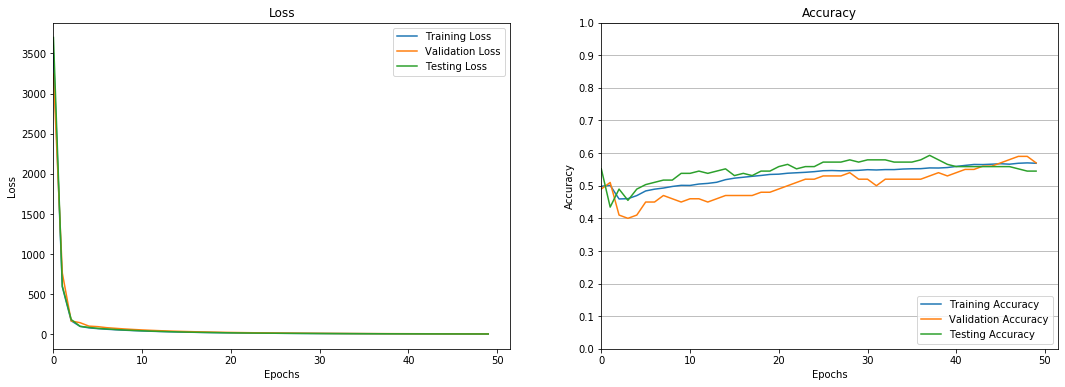

alpha = 0.001
Training loss: 47.4681                    Training acc: 52.29%
Validation loss: 65.2522                  Validation acc: 49.00%
Testing loss: 47.3084                     Testing acc: 57.24%


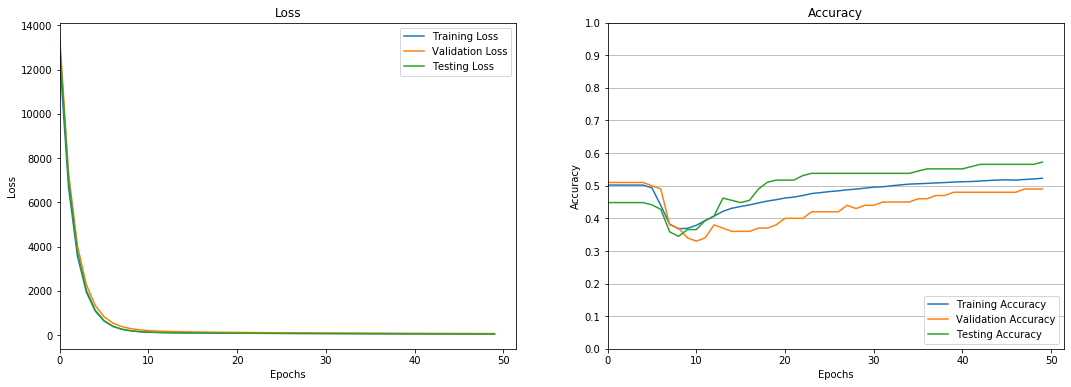

alpha = 0.0001
Training loss: 1503.4686                    Training acc: 50.20%
Validation loss: 1740.2920                  Validation acc: 51.00%
Testing loss: 1549.7111                     Testing acc: 44.83%


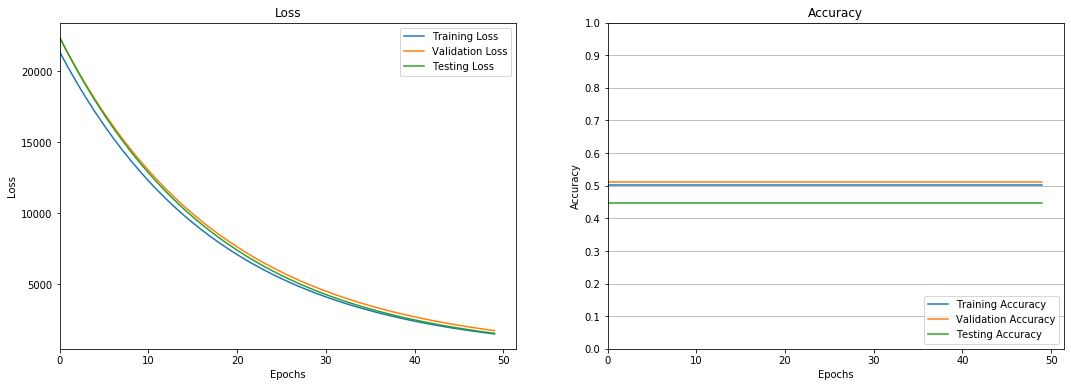

In [13]:
# Test your implementation of Gradient Descent with 5000 epochs and \lambda = 0. Investigate the
# impact of learning rate, \alpha = 0.005, 0.001, 0.0001 on the performance of your classifier. 
# Plot the training, validation and test losses.

N = trainData.shape[0]
d = trainData.shape[1] * trainData.shape[2]
for alpha in [0.005, 0.001, 0.0001]:
    
    print("alpha =", alpha)
    
    w = np.random.random_sample(d)
    b = np.random.random_sample(1)
    w, b, *statistics = grad_descent_MSE(w, b, trainData, trainTarget, alpha, 50, 0, 0.01, validData, validTarget, testData, testTarget)
    train_loss, train_acc, valid_loss, valid_acc, test_loss, test_acc = statistics
    
    print(f"Training loss: {train_loss[-1]:.4f}{'':20s}Training acc: {train_acc[-1]*100:.2f}%")
    print(f"Validation loss: {valid_loss[-1]:.4f}{'':18s}Validation acc: {valid_acc[-1]*100:.2f}%")
    print(f"Testing loss: {test_loss[-1]:.4f}{'':21s}Testing acc: {test_acc[-1]*100:.2f}%")
    
    fig, ax = plt.subplots(1, 2, figsize=(18, 6))
    plot_loss(np.arange(0, len(train_loss), 1), train_loss, valid_loss, test_loss, ax=ax[0])
    plot_accuracy(np.arange(0, len(train_loss), 1), train_acc, valid_acc, test_acc, ax=ax[1])
    plt.show()
    plt.close()

### 4. Generalization

In [14]:
# Investigate impact by modifying the regularization parameter, \lambda = {0.001, 0.1, 0.5}. 
# Plot the training, validation and test loss for \alpha = 0:005 and report the final training, 
# validation and test accuracy of your classifier.

# Sandra

### 5. Comparing Batch GD with normal equation

In [15]:
def least_squares(X, y):
    N = X.shape[0]
    d = X.shape[1] * X.shape[2]
    X, _ = augment(X, np.zeros(X.shape[0]), 0)
    y = y.reshape(-1)
    
    # overparameterized (deep learning)
    if N < d:
        w_aug = X.T.dot(np.linalg.inv( np.dot(X, X.T) )).dot(y)
    # underparameterized (typical case)
    else:
        w_aug = np.linalg.inv( X.T @ X ) @ X.T @ y
    
    return w_aug[1:], w_aug[0]
        
# compare above to gradient descent solution
w_LS, b_LS = least_squares(trainData, trainTarget)

loss = MSE(w_LS, b_LS, trainData, trainTarget, 0)
acc = accuracy(w_LS, b_LS, trainData, trainTarget)
print(f"Least Squares Training loss: {loss:.4f}\tLeast Squares Training acc: {100*acc:.2f}%")
loss = MSE(w_LS, b_LS, validData, validTarget, 0)
acc = accuracy(w_LS, b_LS, validData, validTarget)
print(f"Least Squares Validation loss: {loss:.4f}\tLeast Squares Validation acc: {100*acc:.2f}%")
loss = MSE(w_LS, b_LS, testData, testTarget, 0)
acc = accuracy(w_LS, b_LS, testData, testTarget)
print(f"Least Squares Testing loss: {loss:.4f}\tLeast Squares Testing acc: {100*acc:.2f}%")

Least Squares Training loss: 0.0187	Least Squares Training acc: 71.29%
Least Squares Validation loss: 0.0476	Least Squares Validation acc: 69.00%
Least Squares Testing loss: 0.0570	Least Squares Testing acc: 66.90%


With the analytical solution, the training loss achieved with the analytical equation is 0.0187 with a training accuracy of 71.29%. The training loss and accuracies for batch gradient descent were respectively 0.6918 and 67.97%. From the values, we see that the analytical solution performed better. However, computing it grows increasingly difficult with the size of the problem. As the problem scales, batch gradient descent allows for faster convergence with comparable accuracies.

# 2 Logistic Regression
## 2.1 Binary cross-entropy loss
### 1. Loss Function and Gradient

$$
\sigma(z) = \frac{1}{1 + e^{-z}}
$$

$$
\hat{y}^{(n)} = \sigma(W^T\textbf{x}^{(n)} + b)
$$

$$
\mathcal{L}_{CE} = \frac{1}{N}\sum_{n=1}^{N} \left [ -y^{(n)} \log(\hat{y}^{(n)}) -(1- y^{(n)}) \log (1 - \hat{y}^{(n)} ) \right ] + \frac{\lambda}{2} \Vert W \Vert^2_2
$$

$$
\frac{\partial \mathcal{L}_{CE}}{\partial b} = \frac{1}{N} \sum_{n=1}^{N} \left [ \hat{y}^{(n)} - y^{(n)} \right ]
$$

$$
\frac{\partial \mathcal{L}_{CE}}{\partial W} = \frac{1}{N} \sum_{n=1}^{N} \left [ (\hat{y}^{(n)} - y^{(n)}) \ \textbf{x}^{(n)} \right ] + \lambda W
$$

In [16]:
# this will work for both scalar and vector z
def sigmoid(z):
    return 1.0 / (1 + np.exp(-z))
    

# Cross Entropy Loss
def crossEntropyLoss(w, b, X, y, reg):    
    X, w = augment(X, w, b)
    y = y.reshape(-1)
    N = y.shape[0]
    
    y_hat = sigmoid(X.dot(w))
    
    return 1.0/N * (-y.dot(np.log(y_hat+1e-20)) - (1 - y).dot(np.log(1 - y_hat+1e-20))) + reg/2.0 * np.square(w[1:]).sum()
    

def gradCE(w, b, X, y, reg):
    X, w = augment(X, w, b)
    y = y.reshape(-1)
    N = y.shape[0]
    
    y_hat = sigmoid(X.dot(w))
    
    w_grad = 1.0 /N * X.T.dot(y_hat - y) + reg * w
    
    return w_grad[1:], w_grad[0] - reg * w[0]

"""
# Test that the CE function works
from sklearn.metrics import log_loss

X = trainData
y = trainTarget
N = X.shape[0]
d = X.shape[1] * X.shape[2]

w = np.random.random_sample(d)
b = np.random.random_sample(1)

y_pred = sigmoid(predict(w_LS, b_LS, X))
print(log_loss(y, y_pred))
print(crossEntropyLoss(w_LS, b_LS, X, y, 0))
"""

'\n# Test that the CE function works\nfrom sklearn.metrics import log_loss\n\nX = trainData\ny = trainTarget\nN = X.shape[0]\nd = X.shape[1] * X.shape[2]\n\nw = np.random.random_sample(d)\nb = np.random.random_sample(1)\n\ny_pred = sigmoid(predict(w_LS, b_LS, X))\nprint(log_loss(y, y_pred))\nprint(crossEntropyLoss(w_LS, b_LS, X, y, 0))\n'

### 2. Learning

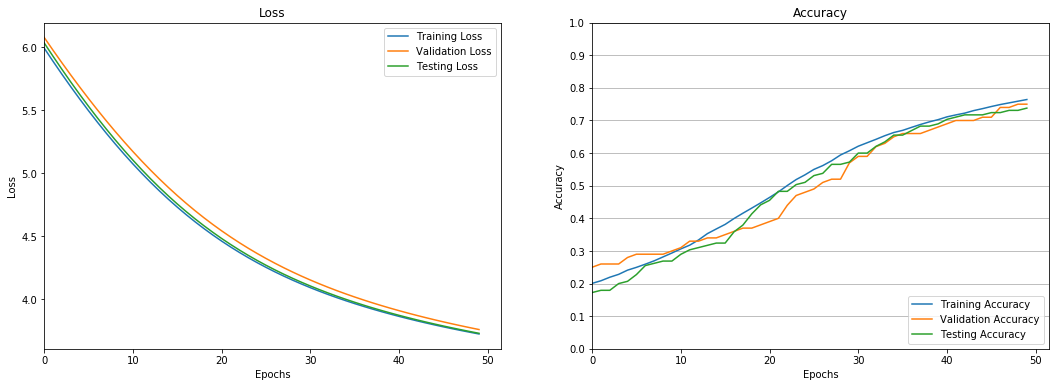

In [17]:
def grad_descent(w, b, X, y, alpha, epochs, reg, error_tol, lossType="MSE", 
                 validData=None, validTarget=None, testData=None, testTarget=None):
    loss_func, grad_func = None, None
    if lossType == "MSE":
        loss_func, grad_func = MSE, gradMSE
    elif lossType == "CE":
        loss_func, grad_func = crossEntropyLoss, gradCE
    else:
        raise ValueError("Variable 'lossType' must be either 'MSE' or 'CE'.")
    
    train_loss, train_acc = [], []
    valid_loss, valid_acc = [], []
    test_loss, test_acc = [], []
    printing = False
    for i in range(epochs):
        grad_w, grad_b = grad_func(w, b, X, y, reg)
        w -= alpha * grad_w
        b -= alpha * grad_b

        # Calculating Statistics
        train_loss.append(loss_func(w, b, X, y, reg))
        train_acc.append(accuracy(w, b, X, y))

        if validData is not None and validTarget is not None:
            valid_loss.append(loss_func(w, b, validData, validTarget, reg))
            valid_acc.append(accuracy(w, b, validData, validTarget))
        if testData is not None and testTarget is not None:
            test_loss.append(loss_func(w, b, testData, testTarget, reg))
            test_acc.append(accuracy(w, b, testData, testTarget))

        # Print Losses and Accurancies if printing is on
        if printing:
            print(f"Training loss: {train_loss[-1]:.4f}{'':20s}Training acc: {train_acc[-1] * 100:.2f}%")
            if validData is not None and validTarget is not None:
                print(f"Validation loss: {valid_loss[-1]:.4f}{'':18s}Validation acc: {valid_acc[-1] * 100:.2f}%")
            if testData is not None and testTarget is not None:
                print(f"Testing loss: {test_loss[-1]:.4f}{'':21s}Testing acc: {test_acc[-1] * 100:.2f}%")

        # Check stopping condition
        if i > 1 and np.abs(train_loss[-2] - train_loss[-1]) <= error_tol:
            break

    statistics = (train_loss, train_acc)
    if validData is not None and validTarget is not None:
        statistics += (valid_loss, valid_acc,)
    if testData is not None and testTarget is not None:
        statistics += (test_loss, test_acc,)
    out = (w, b, *statistics)

    return out
        
X = trainData
N = X.shape[0]
d = X.shape[1] * X.shape[2]

w = np.random.random_sample(d)
w = w - w.mean()
b = np.random.random_sample(1)
w, b, *statistics = grad_descent(w, b, trainData, trainTarget, 0.005, 50, 0.1, 0.0001, "CE", validData, validTarget, testData, testTarget)
train_loss, train_acc, valid_loss, valid_acc, test_loss, test_acc = statistics
#train_loss, train_acc = statistics

fig, ax = plt.subplots(1, 2, figsize=(18, 6))
plot_loss(np.arange(0, len(train_loss), 1), train_loss, valid_loss, test_loss, ax=ax[0])
plot_accuracy(np.arange(0, len(train_loss), 1), train_acc, valid_acc, test_acc, ax=ax[1])
plt.show()

# oops, I (Dev) kinda started doing this one by mistake. All that's left is the plotting of the curves
# Eric

### 3. Comparision to Linear Regression

In [18]:
# For zero weight decay, learning rate of 0.005 and 5000 epochs, 
# plot the training cross entropy loss and MSE loss for 
# logistic regression and linear regression respectively.
# Comment on the effect of cross-entropy loss convergence behaviour.

# Sandra

# 3 Batch Gradient Descent vs. SGD and Adam
## 3.1 SGD
### 1. Building the Computational Graph

In [19]:
def buildGraph(loss="MSE"):
    #Initialize weight and bias tensors
    tf.set_random_seed(421)

    if loss == "MSE":
        # Your implementation
        pass
    elif loss == "CE":
        #Your implementation here
        pass
    else:
        raise ValueError("Variable 'lossType' must be either 'MSE' or 'CE'.")

# Come back to this later

### 2. Implementing Stochastic Gradient Descent

In [20]:
class BatchLoader(object):

    def __init__(self, data, batch_size=None, randomize=True, drop_last=False, seed=None):
    
        # error checking
        if len(data) > 1:
            for i in range(len(data)-1):
                if data[i].shape[0] != data[i+1].shape[0]:
                    raise ValueError("All inputs must have the same number of elements")
    
        self.data = data if type(data) == tuple else (data, )
        self.N = data[0].shape[0]
        self.batch_size = batch_size if batch_size != None else self.N
        self.drop_last = drop_last

        # shuffling data
        if randomize:
            indices = np.arange(self.N)
            np.random.seed(seed)
            np.random.shuffle(indices)
            self.data = tuple([d[indices] for d in self.data])
    
        self.index = 0 

    def __iter__(self):
        return self
    
    def __next__(self):
    
        # stop condition
        if self.index >= self.N:
            self.index = 0          # resetting index for next iteration
            raise StopIteration

        # iterating
        self.index += self.batch_size
    
        if self.index > self.N:
            if self.drop_last:
                self.index = 0      # resetting index for next iteration
                raise StopIteration
            else:
                #return self.index - self.batch_size, "end"
                return tuple([ d[self.index - self.batch_size: ] for d in self.data ])
        else:
            #return self.index - self.batch_size, self.index
            return tuple([ d[self.index - self.batch_size: self.index] for d in self.data ])

In [21]:
# Implement the SGD algorithm for a minibatch size of 500 

def SGD(w, b, X, y, alpha, epochs, reg, error_tol, batch_size, lossType="CE", 
                 validData=None, validTarget=None, testData=None, testTarget=None, randomize=False):
    loss_func, grad_func = None, None
    if lossType == "MSE":
        loss_func, grad_func = MSE, gradMSE
    elif lossType == "CE":
        loss_func, grad_func = crossEntropyLoss, gradCE
    else:
        raise ValueError("Variable 'lossType' must be either 'MSE' or 'CE'.")
    
    train_loss, train_acc = [], []
    valid_loss, valid_acc = [], []
    test_loss, test_acc = [], []
    printing = False
    
    batch_iter = BatchLoader((X, y), batch_size=batch_size)
    
    running_loss = 0.0
    running_acc = 0.0
    
    for i in range(epochs):
        for batch, targets in batch_iter:
            grad_w, grad_b = grad_func(w, b, batch, targets, reg)
            w -= alpha * grad_w
            b -= alpha * grad_b
            
            # Calculating Statistics
            running_loss += loss_func(w, b, batch, targets, reg) * batch.shape[0]
            running_acc += accuracy(w, b, batch, targets) * batch.shape[0]
            
            # Check stopping condition
            if i > 1 and np.abs(train_loss[-2] - train_loss[-1]) <= error_tol:
                break
        else:
            # Calculating Statistics
            train_loss.append(running_loss / X.shape[0])
            train_acc.append(running_acc / X.shape[0])
            running_loss = 0.0
            running_acc = 0.0
            
            if validData is not None and validTarget is not None:
                valid_loss.append(loss_func(w, b, validData, validTarget, reg))
                valid_acc.append(accuracy(w, b, validData, validTarget))
            if testData is not None and testTarget is not None:
                test_loss.append(loss_func(w, b, testData, testTarget, reg))
                test_acc.append(accuracy(w, b, testData, testTarget))

            # Print Losses and Accurancies if printing is on
            if printing:
                print(f"Training loss: {train_loss[-1]:.4f}{'':20s}Training acc: {train_acc[-1] * 100:.2f}%")
                if validData is not None and validTarget is not None:
                    print(f"Validation loss: {valid_loss[-1]:.4f}{'':18s}Validation acc: {valid_acc[-1] * 100:.2f}%")
                if testData is not None and testTarget is not None:
                    print(f"Testing loss: {test_loss[-1]:.4f}{'':21s}Testing acc: {test_acc[-1] * 100:.2f}%")
            
            continue
        break

    statistics = (train_loss, train_acc)
    if validData is not None and validTarget is not None:
        statistics += (valid_loss, valid_acc,)
    if testData is not None and testTarget is not None:
        statistics += (test_loss, test_acc,)
    out = (w, b, *statistics)

    return out

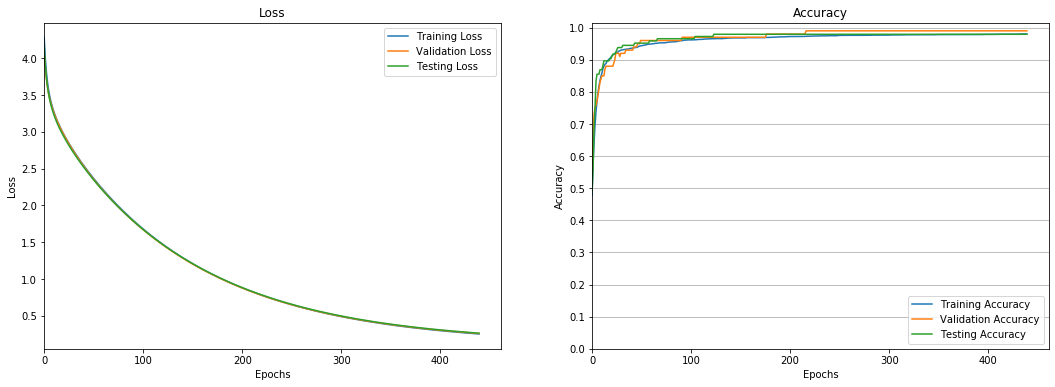

In [22]:
# optimizing over 700 epochs 2, minimizing the MSE (you will repeat this for the CE later).
# Calculate the total number of batches required by dividing the number
# of training instances by the minibatch size. After each epoch you will need to reshuffle the
# training data and start sampling from the beginning again. Initially, set \lambda = 0 and continue
# to use the same \alpha value (i.e. 0.001). After each epoch, store the training, validation and test
# losses and accuracies. Use these to plot the loss and accuracy curves.
X = trainData
N = X.shape[0]
d = X.shape[1] * X.shape[2]

w = np.random.random_sample(d)
w = w - w.mean()
b = np.random.random_sample(1)
w, b, *statistics = SGD(w, b, trainData, trainTarget, 0.005, 700, 0.1, 0.001, 500, "CE", validData, validTarget, testData, testTarget)
train_loss, train_acc, valid_loss, valid_acc, test_loss, test_acc = statistics
#train_loss, train_acc = statistics

fig, ax = plt.subplots(1, 2, figsize=(18, 6))
plot_loss(np.arange(0, len(train_loss), 1), train_loss, valid_loss, test_loss, ax=ax[0])
plot_accuracy(np.arange(0, len(train_loss), 1), train_acc, valid_acc, test_acc, ax=ax[1])
plt.show()

### 3. Batch Size Investigation

batch size = 100
Training loss: 0.2015                    Training acc: 97.57%
Validation loss: 0.4524                  Validation acc: 96.00%
Testing loss: 0.5087                     Testing acc: 97.24%


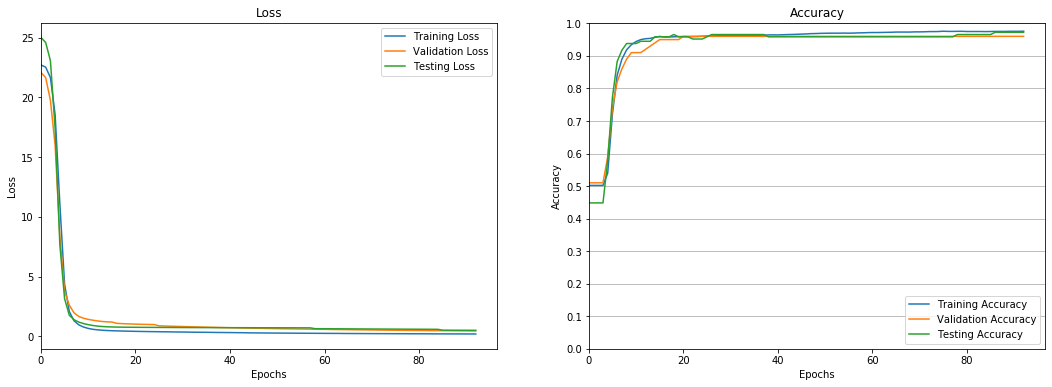

batch size = 700
Training loss: 0.3699                    Training acc: 96.57%
Validation loss: 1.0540                  Validation acc: 94.00%
Testing loss: 0.7815                     Testing acc: 96.55%


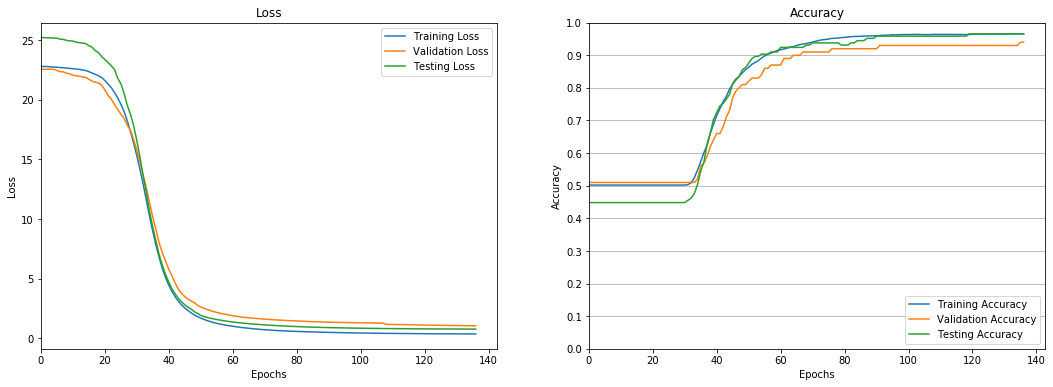

batch size = 1750
Training loss: 0.4709                    Training acc: 95.46%
Validation loss: 1.3326                  Validation acc: 92.00%
Testing loss: 0.7715                     Testing acc: 96.55%


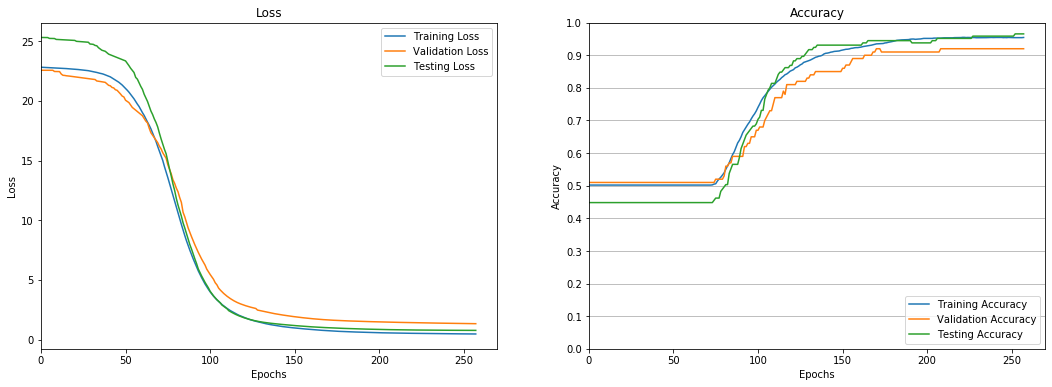

In [23]:
# Eric
N = trainData.shape[0]
d = trainData.shape[1] * trainData.shape[2]
for batch_size in [100, 700, 1750]:
    
    print("batch size =", batch_size)
    
    w = np.random.random_sample(d)
    b = np.random.random_sample(1)
    w, b, *statistics = SGD(w, b, trainData, trainTarget, 0.01, 700, 0, 0.001, batch_size, 'CE', validData, validTarget, testData, testTarget)
    train_loss, train_acc, valid_loss, valid_acc, test_loss, test_acc = statistics
    
    print(f"Training loss: {train_loss[-1]:.4f}{'':20s}Training acc: {train_acc[-1]*100:.2f}%")
    print(f"Validation loss: {valid_loss[-1]:.4f}{'':18s}Validation acc: {valid_acc[-1]*100:.2f}%")
    print(f"Testing loss: {test_loss[-1]:.4f}{'':21s}Testing acc: {test_acc[-1]*100:.2f}%")
    
    fig, ax = plt.subplots(1, 2, figsize=(18, 6))
    plot_loss(np.arange(0, len(train_loss), 1), train_loss, valid_loss, test_loss, ax=ax[0])
    plot_accuracy(np.arange(0, len(train_loss), 1), train_acc, valid_acc, test_acc, ax=ax[1])
    plt.show()
    plt.close()

### 4. Hyperparameter Investigation

In [24]:
# Sandra

### 5. Cross Entropy Loss Investigation

In [25]:
# anyone

### 6. Comparison against Batch GD

In [26]:
# Sandra